# COVID-19 and CA hospitals

### Load python tools

In [1]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()
from selenium import webdriver
driver = webdriver.Chrome(executable_path='/Users/mhustiles/Desktop/chromedriver')

### Hospital building characteristics

In [2]:
#https://data.chhs.ca.gov/dataset/hospital-building-data
#Metadata: https://data.chhs.ca.gov/dataset/hospital-building-data/resource/cefc10e5-5071-4ca4-8b03-2249caf0d294
buildings = pd.read_csv('input/ca-oshpd-gachospital-building-03052020.csv', encoding='Latin-1',\
                        dtype={'year_completed': object, 'building_code_year': object, 'stories': int,\
                               'height_ft': int}).fillna('')

In [3]:
buildings.columns = buildings.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [4]:
buildings.head()

,county_code,perm_id,facility_name,city,building_nbr,building_name,building_status,spc_rating_*,building_url,height_ft,stories,building_code,building_code_year,year_completed,latitude,longitude,count
0,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01278,Original Hospital,In Service,1,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,44.17,4,Unknown,,1926,37.762657,-122.253899,1
1,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01279,Stephens Wing,In Service,1,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,35,3,1952 Uniform Building Code (UBC),1952,1956,37.762657,-122.253899,1
2,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01280,West Wing,In Service,2,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,,2,1964 Uniform Building Code (UBC),1964,1968,37.762657,-122.253899,1
3,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01281,South Wing,In Service,3s,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,,3,1976 California Building Code (CBC),1976,1983,37.762657,-122.253899,1
4,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01282,Radiology Addition,In Service,5s,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,,2,1985 California Building Code (CBC),1985,1995,37.762657,-122.253899,1


In [5]:
buildings_geo = gpd.GeoDataFrame(
    buildings, geometry=gpd.points_from_xy(buildings.longitude, buildings.latitude))

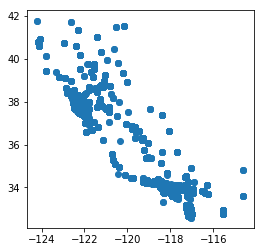

In [6]:
buildings_geo.plot()

--- 

### Facility listing

In [7]:
#https://data.chhs.ca.gov/dataset/healthcare-facility-locations/resource/0a0476ba-442c-40ff-97dc-dc840fa7e907
facilities = pd.read_excel('input/healthcare_facility_locations.xlsx')

In [8]:
facilities.columns = facilities.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [9]:
facilities_geo = gpd.GeoDataFrame(
    facilities, geometry=gpd.points_from_xy(facilities.longitude, facilities.latitude))

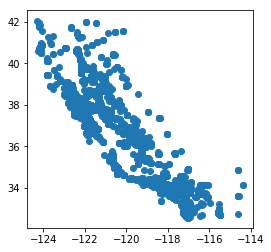

In [10]:
facilities_geo.plot()

In [11]:
hospitals = facilities_geo[facilities_geo['fac_type_code'] == 'GACH']

In [12]:
hospitals['entity_type_description'].value_counts()

NONPROFIT CORP               215
LIMITED LIABILITY COMPANY     65
PROFIT CORP                   49
HEALTH CARE DISTRICT          34
PARTNERSHIP                   19
COUNTY                        17
UC REGENT                      9
OTHER PUBLIC AGENCY            5
INDIVIDUAL                     1
CITY                           1
STATE AGENCY                   1
Name: entity_type_description, dtype: int64

In [13]:
hospitals.head()

,facid,npi,facname,fac_type_code,fac_fdr,ltc,capacity,address,city,zip,zip9,facadmin,contact_email,contact_fax,contact_phone_number,county_code,county_name,district_number,district_name,isfacmain,license_number,business_name,initial_license_date,license_effective_date,license_expiration_date,entity_type_description,latitude,longitude,location,oshpd_id,streetnum,streetname,cclho_code,cclho_name,fips_county_code,birthing_facility_flag,trauma_ped_ctr,trauma_ctr,type_of_care,critical_access_hospital,geometry
243,30000037,1467560599,METHODIST HOSPITAL OF SACRAMENTO,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,158,7500 HOSPITAL DRIVE,SACRAMENTO,95823,5403.0,"BALTZ, PHYLLIS A",MARI.SHELTON@DIGNITYHEALTH.ORG,(916) 423-6045,(916) 423-3000,440,SACRAMENTO,3,SACRAMENTO,Y,30000064.0,DIGNITY COMMUNITY CARE,1980-06-30,2019-12-31,2020-12-30,NONPROFIT CORP,38.463530,-121.416061,"(-121.416061,38.46353)",106340951.0,7500,HOSPITAL DRIVE,34,SACRAMENTO,6067,YES,NaN,NaN,NaN,NaN,POINT (-121.41606 38.46353)
261,30000108,1447494323,SUTTER AMADOR HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,52,200 MISSION BOULEVARD,JACKSON,95642,2564.0,"DICKSON, THOMAS",SAMMOND@SUTTERHEALTH.ORG,(209) 223-7454,(209) 223-7500,20,AMADOR,3,SACRAMENTO,Y,30000008.0,SUTTER VALLEY HOSPITALS,1979-05-01,2019-11-01,2020-10-31,NONPROFIT CORP,38.350190,-120.764621,"(-120.764621,38.35019)",106034002.0,200,MISSION BOULEVARD,3,AMADOR,6005,YES,NaN,NaN,NaN,NaN,POINT (-120.76462 38.35019)
262,30000109,1194774299,SUTTER AUBURN FAITH HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,64,11815 EDUCATION STREET,AUBURN,95602,2410.0,"HANNA, MITCHELL J",ZOBELC@SUTTERHEALTH.ORG,(530) 886-6611,(530) 888-4557,410,PLACER,3,SACRAMENTO,Y,30000012.0,SUTTER VALLEY HOSPITALS,1966-06-30,2019-07-26,2020-05-30,NONPROFIT CORP,38.945570,-121.100331,"(-121.100331,38.94557)",106310791.0,11815,EDUCATION STREET,31,PLACER,6061,NaN,NaN,NaN,NaN,NaN,POINT (-121.10033 38.94557)
263,30000113,1710918545,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,625,2315 STOCKTON BOULEVARD,SACRAMENTO,95817,2201.0,"SIMMONS, BRADLEY",LTNAVARRA@UCDAVIS.EDU,(916) 734-3234,(916) 734-2011,440,SACRAMENTO,3,SACRAMENTO,Y,30000086.0,UNIVERSITY OF CALIFORNIA BOARD OF REGENTS,1953-08-26,2019-12-06,2020-04-07,UC REGENT,38.554290,-121.455181,"(-121.455181,38.55429)",106341006.0,2315,STOCKTON BOULEVARD,34,SACRAMENTO,6067,YES,LEVEL I PED,LEVEL I,NaN,NaN,POINT (-121.45518 38.55429)
264,30000114,1003867565,BARTON MEMORIAL HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,63,2170 SOUTH AVENUE,SOUTH LAKE TAHOE,96150,7025.0,"PURVANCE, CLINTON D",PUBLICRELATIONS@BARTONHEALTH.ORG,(530) 541-4697,(530) 541-3420,80,EL DORADO,3,SACRAMENTO,Y,30000013.0,BARTON HEALTHCARE SYSTEM,1963-11-21,2019-07-11,2020-06-29,NONPROFIT CORP,38.912319,-119.996583,"(-119.996583,38.912319)",106090793.0,2170,SOUTH AVENUE,9,EL DORADO,6017,YES,NaN,LEVEL III,NaN,NaN,POINT (-119.99658 38.91232)


In [14]:
public_list = ['COUNTY','UC REGENT','OTHER PUBLIC AGENCY','CITY','STATE AGENCY']

In [15]:
public = hospitals[hospitals['entity_type_description'].isin(public_list)]

In [16]:
public.to_csv('output/public_hospitals_from_chhs.csv')

In [17]:
public.contact_email.tolist()

['LTNAVARRA@UCDAVIS.EDU',
 'INFO@SJGH.ORG',
 nan,
 'DFINLEY@DHS.LACOUNTY.GOV',
 'LZMARTINEZ@DHS.LACOUNTY.GOV',
 nan,
 'DCASTILLO@DHS.LACOUNTY.GOV',
 'DBOURGET@UCI.EDU',
 'LICENSINGANDCERTIFICATION@NATIVIDAD.COM',
 'PATRYAN@VERITY.ORG',
 'HOSPITAL.ADMIN@HHS.SCCGOV.ORG',
 'CORRIERUDD@VERIFY.ORG',
 'ADOLPHE.EDWARD@ECRMC.ORG',
 'POLSEN@UCSD.EDU',
 nan,
 'RON.EYRAUD@KERNMEDICAL.COM',
 'RISKMANAGEMENT@ALAMEDAHEALTHSYSTEM.ORG',
 nan,
 'ADALY@ACMEDCTR.ORG',
 'JASPREET.BENEPAL@CCHEALTH.ORG',
 nan,
 'CKUNNAPPILLY@SMCGOV.ORG',
 nan,
 nan,
 nan,
 nan,
 'HOGGANE@ARMC.SBCOUNTY.GOV',
 nan,
 nan,
 'JAJACKSON@ACMEDCTR.ORG',
 nan,
 'PWATKINS@MEDNET.UCLA.EDU',
 'MBWILLIS@MEDNET.UCLA.EDU']

In [18]:
len(public)

33

In [19]:
public.head()

,facid,npi,facname,fac_type_code,fac_fdr,ltc,capacity,address,city,zip,zip9,facadmin,contact_email,contact_fax,contact_phone_number,county_code,county_name,district_number,district_name,isfacmain,license_number,business_name,initial_license_date,license_effective_date,license_expiration_date,entity_type_description,latitude,longitude,location,oshpd_id,streetnum,streetname,cclho_code,cclho_name,fips_county_code,birthing_facility_flag,trauma_ped_ctr,trauma_ctr,type_of_care,critical_access_hospital,geometry
263,30000113,1710918545,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,625,2315 STOCKTON BOULEVARD,SACRAMENTO,95817,2201.0,"SIMMONS, BRADLEY",LTNAVARRA@UCDAVIS.EDU,(916) 734-3234,(916) 734-2011,440,SACRAMENTO,3,SACRAMENTO,Y,30000086.0,UNIVERSITY OF CALIFORNIA BOARD OF REGENTS,1953-08-26,2019-12-06,2020-04-07,UC REGENT,38.554290,-121.455181,"(-121.455181,38.55429)",106341006.0,2315,STOCKTON BOULEVARD,34,SACRAMENTO,6067,YES,LEVEL I PED,LEVEL I,NaN,NaN,POINT (-121.45518 38.55429)
279,30000135,1275605180,SAN JOAQUIN GENERAL HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,152,500 W. HOSPITAL ROAD,FRENCH CAMP,95231,9693.0,"CULBERSON, DAVID",INFO@SJGH.ORG,(209) 468-7011,(209) 468-6000,490,SAN JOAQUIN,3,SACRAMENTO,Y,30000087.0,COUNTY OF SAN JOAQUIN,1953-07-01,2020-01-01,2020-10-31,COUNTY,37.886550,-121.282211,"(-121.282211,37.88655)",106391010.0,500,W. HOSPITAL ROAD,39,SAN JOAQUIN,6077,YES,NaN,LEVEL III,NaN,NaN,POINT (-121.28221 37.88655)
698,50000039,1629167457,VENTURA COUNTY MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,180,300 HILLMONT AVE,VENTURA,93003,3099.0,"FANKHAUSER, JOHN",NaN,(805) 652-6169,(805) 652-6075,660,VENTURA,5,VENTURA,Y,50000032.0,COUNTY OF VENTURA,1953-07-01,2020-03-01,2021-02-28,COUNTY,34.279145,-119.254337,"(-119.254337,34.279145)",106560481.0,300,HILLMONT AVE,56,VENTURA,6111,YES,NaN,LEVEL II,NaN,NaN,POINT (-119.25434 34.27914)
918,60000027,1295757938,LAC/HARBOR UCLA MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,415,1000 W CARSON ST,TORRANCE,90502,2004.0,"MCKENZIE, KIMBERLY",DFINLEY@DHS.LACOUNTY.GOV,(310) 328-9624,(310) 222-2345,200,LOS ANGELES,6,ORANGE,Y,60000129.0,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,1953-07-01,2019-05-01,2020-04-30,COUNTY,33.831540,-118.294551,"(-118.294551,33.83154)",106191227.0,1000,W CARSON ST,19,LOS ANGELES,6037,YES,LEVEL II PED,LEVEL I,NaN,NaN,POINT (-118.29455 33.83154)
919,60000028,1336156363,LAC/RANCHO LOS AMIGOS NATIONAL REHABILITATION ...,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,158,7601 IMPERIAL HWY,DOWNEY,90242,3456.0,"OROZCO, JORGE",LZMARTINEZ@DHS.LACOUNTY.GOV,(562) 803-0056,(562) 385-7022,200,LOS ANGELES,6,ORANGE,Y,60000161.0,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,1953-07-01,2020-01-23,2020-03-30,COUNTY,33.929100,-118.158001,"(-118.158001,33.9291)",106191306.0,7601,IMPERIAL HWY,19,LOS ANGELES,6037,NaN,NaN,NaN,NaN,NaN,POINT (-118.15800 33.92910)


---

### CDC testing capacity

In [20]:
tables = pd.read_html('https://www.cdc.gov/coronavirus/2019-ncov/cases-updates/testing-in-us.html?CDC_AA_refVal=https%3A%2F%2Fwww.cdc.gov\
%2Fcoronavirus%2F2019-ncov%2Ftesting-in-us.html',  header=0)

In [21]:
tables = pd.DataFrame(tables[0])

In [22]:
tables.columns = tables.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [23]:
tables.rename(columns={"us_public_health_labs": "US Public Health Labs",\
                   "cdc_labs": "CDC Labs", 'date_collected':'Date'}, inplace=True)

In [24]:
tables['Date'] = pd.to_datetime(tables['Date'] + '/2020')

In [25]:
# tables = tables[tables['Date'] <= '2020/03/10']

In [26]:
tables_melt = pd.melt(tables, id_vars=['Date'], value_vars=['US Public Health Labs', 'CDC Labs'],
        var_name='lab_type', value_name='test_count')

In [27]:
tables.to_csv('output/cdc_testing_table.csv')
tables_melt.to_csv('output/cdc_testing_table_melt.csv')

In [28]:
tables_melt['test_count'] = tables_melt['test_count'].str.replace('‡','').astype(int)

In [29]:
tables_melt.head()

,Date,lab_type,test_count
0,2020-01-18,US Public Health Labs,0
1,2020-01-19,US Public Health Labs,0
2,2020-01-20,US Public Health Labs,0
3,2020-01-21,US Public Health Labs,0
4,2020-01-22,US Public Health Labs,0


In [30]:
chart = alt.Chart(tables_melt).mark_bar(size=12).encode(
    x=alt.X('Date:T', title='Date', axis=alt.Axis(tickCount=10)),
    y=alt.Y('sum(test_count)', title=''),
    color=alt.Color('lab_type', legend=alt.Legend(orient="top"), title=''),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'lab_type',
      sort='ascending'
    )
).properties(width=800, title={
      "text": ["CDC: Daily U.S. coronavirus specimens tested, by lab type"], 
      "subtitle": ["Figures from last four days reported as 'pending'"],
      "color": "black",
      "subtitleColor": "gray"})
  

In [31]:
chart

alt.Chart(...)

In [32]:
chart.save('visualization.png')

In [33]:
chart.save('visualization.svg')

---

### Johns Hopkins data

In [34]:
# Cases: 
# https://services1.arcgis.com/0MSEUqKaxRlEPj5g/ArcGIS/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/1

# Deaths: 
# https://services1.arcgis.com/0MSEUqKaxRlEPj5g/ArcGIS/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/0

# Cases countries: 
# https://services1.arcgis.com/0MSEUqKaxRlEPj5g/ArcGIS/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/2

# Cases/time: 
# https://services1.arcgis.com/0MSEUqKaxRlEPj5g/ArcGIS/rest/services/cases_time_v3/FeatureServer/0

---

### CHHS: Hospital Annual Utilization Report - 2018

In [35]:
# https://data.chhs.ca.gov/dataset/hospital-annual-utilization-report
# pivot table: https://data.chhs.ca.gov/dataset/hospital-annual-utilization-report/resource/4ee65e8c-ca6e-42d3-9aec-adcc56383856

In [36]:
utilization = pd.read_csv('input/2018_hosp_util_pivot_20191231.csv')

In [37]:
utilization.columns = utilization.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [38]:
utilization.rename(columns={"ic_cen_days": "icu_days", "ic_lic_bed_days": "icu_bed_days",\
                     'ic_lic_beds':'icu_beds'}, inplace=True)

In [39]:
utilization.head()

,oshpd_id,fac_no,fac_name,fac_str_addr,fac_city,fac_zip,fac_operated_this_yr,fac_op_per_begin_dt,fac_op_per_end_dt,fac_par_corp_name,license_no,license_eff_date,license_exp_date,license_status,facility_level,trauma_ctr,teach_hosp,teach_rural,longitude,latitude,assembly_dist,senate_dist,congress_dist,cens_tract,med_svc_study_area,...,level_i_trauma,level_ii_trauma,level_iii_trauma,level_iv_trauma,emsa_ped,level_i_ped,level_ii_ped,level_iii_ped,level_iv_ped,emsa_trauma,emsa_either,non_emsa,level_i_visit,level_ii_visit,level_iii_visit,level_iv_visit,non_emsa_visit,minor_tot,lowm_tot,mod_tot,sev_tot,crit_tot,unk_acuity_not_adm,unk_acuity_adm,unknown_sev
0,106010735,106010735,ALAMEDA HOSPITAL,2070 CLINTON AVE,ALAMEDA,94501,Yes,01/01/2018,12/31/2018,Alameda Health System,140000002,10/30/2018,04/30/2019,Open,Parent Facility,NaN,No,No,-122.253991,37.76266,District 18,District 09,District 13,6.001428e+09,2e,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,16469,762,2871,6566,4226,2044,0,0,0
1,106010739,106010739,ALTA BATES SUMMIT MEDICAL CENTER-ALTA BATES CA...,2450 ASHBY AVENUE,BERKELEY,94705,Yes,01/01/2018,12/31/2018,Sutter Health,140000004,11/01/2017,10/31/2018,Open,Parent Facility,NaN,No,No,-122.257430,37.85645,District 15,District 09,District 13,6.001424e+09,2b,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,45958,545,3819,10529,15099,10614,0,5352,5352
2,106010776,106010776,UCSF BENIOFF CHILDREN'S HOSPITAL OAKLAND,747 52ND STREET,OAKLAND,94609,Yes,01/01/2018,12/31/2018,NaN,140000015,11/20/2018,12/31/2018,Open,Parent Facility,Level I - Pediatric,No,No,-122.267470,37.83722,District 15,District 09,District 13,6.001401e+09,2c,...,0,0,0,0,1,1,0,0,0,1,1,0,44808,0,0,0,0,821,7810,22156,6758,7263,0,0,0
3,106010811,106010811,FAIRMONT HOSPITAL,15400 FOOTHILL BOULEVARD,SAN LEANDRO,94578,Yes,01/01/2018,12/31/2018,Alameda Health System,140000046,11/01/2018,10/31/2019,Open,Consolidated Facility,NaN,No,No,-122.118190,37.70648,District 20,District 10,District 15,6.001430e+09,2f,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,106010844,106010844,ALTA BATES SUMMIT MEDICAL CENTER-HERRICK CAMPUS,2001 DWIGHT WAY,BERKELEY,94704,Yes,01/01/2018,12/31/2018,Sutter Health,140000004,11/01/2017,10/31/2018,Open,Consolidated Facility,NaN,No,No,-122.269840,37.86373,District 15,District 09,District 13,6.001423e+09,2a,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
utilization['icu_occupancy_rate'] = ((utilization.icu_days / utilization.icu_bed_days)*100).round()

In [41]:
utilization_geo = gpd.GeoDataFrame(
    utilization, geometry=gpd.points_from_xy(utilization.longitude, utilization.latitude))

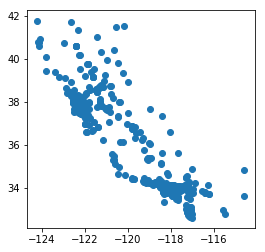

In [42]:
utilization_geo.plot()

In [43]:
utilization_counties = utilization_geo.groupby(['county']).agg({'icu_days':'sum', 'icu_bed_days':'sum', \
                                                  'icu_beds':'sum', 'icu_occupancy_rate':'mean'}).reset_index()

In [44]:
utilization_counties.sort_values(by='icu_beds', ascending=False)

,county,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate
17,Los Angeles,462032.0,780420.0,2174.0,66.244186
28,Orange,127304.0,232259.0,631.0,57.275862
35,San Diego,126475.0,212362.0,540.0,62.600000
34,San Bernardino,126567.0,181040.0,496.0,62.150000
31,Riverside,75210.0,136506.0,378.0,56.166667
32,Sacramento,102886.0,137434.0,376.0,74.400000
41,Santa Clara,84576.0,140160.0,370.0,54.545455
36,San Francisco,63036.0,122925.0,347.0,51.083333
0,Alameda,55392.0,96360.0,264.0,58.133333
5,Contra Costa,42042.0,61902.0,169.0,67.250000


In [45]:
utilization_counties.fillna('').to_csv('output/icu_by_county.csv')

In [46]:
icus = utilization_geo[utilization_geo['icu_beds'] > 0]
icus_slim = icus[[ 'fac_name', 'county', 'icu_beds','icu_days', \
                  'icu_bed_days', 'icu_occupancy_rate', 'geometry' ]]

In [47]:
icus_slim.sort_values(by='icu_beds', ascending=False).head()

,fac_name,county,icu_beds,icu_days,icu_bed_days,icu_occupancy_rate,geometry
188,LAC+USC MEDICAL CENTER,Los Angeles,130.0,27471.0,47450.0,58.0,POINT (-118.21031 34.05982)
153,CEDARS SINAI MEDICAL CENTER,Los Angeles,126.0,31614.0,45990.0,69.0,POINT (-118.38061 34.07681)
175,RONALD REAGAN UCLA MEDICAL CENTER,Los Angeles,120.0,44415.0,43800.0,101.0,POINT (-118.44500 34.06889)
301,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,Sacramento,116.0,32690.0,42534.0,77.0,POINT (-121.45738 38.55438)
341,LOMA LINDA UNIVERSITY CHILDREN'S HOSPITAL,San Bernardino,99.0,23937.0,36135.0,66.0,POINT (-117.26115 34.04915)


In [48]:
len(icus)

349

In [49]:
icus_slim.to_file('output/icus.geojson', driver='GeoJSON')

In [50]:
icus_slim.sort_values(by='icu_beds', ascending=False)

,fac_name,county,icu_beds,icu_days,icu_bed_days,icu_occupancy_rate,geometry
188,LAC+USC MEDICAL CENTER,Los Angeles,130.0,27471.0,47450.0,58.0,POINT (-118.21031 34.05982)
153,CEDARS SINAI MEDICAL CENTER,Los Angeles,126.0,31614.0,45990.0,69.0,POINT (-118.38061 34.07681)
175,RONALD REAGAN UCLA MEDICAL CENTER,Los Angeles,120.0,44415.0,43800.0,101.0,POINT (-118.44500 34.06889)
301,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,Sacramento,116.0,32690.0,42534.0,77.0,POINT (-121.45738 38.55438)
341,LOMA LINDA UNIVERSITY CHILDREN'S HOSPITAL,San Bernardino,99.0,23937.0,36135.0,66.0,POINT (-117.26115 34.04915)
319,LOMA LINDA UNIVERSITY MEDICAL CENTER,San Bernardino,90.0,31174.0,32850.0,95.0,POINT (-117.26146 34.05164)
383,UCSF MEDICAL CENTER,San Francisco,86.0,14940.0,31390.0,48.0,POINT (-122.45766 37.76352)
194,KECK HOSPITAL OF USC,Los Angeles,84.0,24015.0,30660.0,78.0,POINT (-118.20287 34.06284)
133,KAISER FOUNDATION HOSPITAL - LOS ANGELES,Los Angeles,80.0,18521.0,29200.0,63.0,POINT (-118.29537 34.09875)
302,"SUTTER MEDICAL CENTER, SACRAMENTO",Sacramento,80.0,20808.0,29200.0,71.0,POINT (-121.47028 38.57045)


In [51]:
icus_slim.to_csv('output/icu_by_facility.csv')

### ICU bed rate per 100,000 residents

In [52]:
# basically one bed for every 5,350 residents not counting 50% occupancy rate already
(icus_slim.icu_beds.sum()*100000) / 39512223

18.74356702228574

### ICU bed rate per 100,000 residents older than 65 (5.6 million in CA)

In [53]:
# basically one bed for every 37,500 residents over 65 not counting 50% occupancy rate already
(icus_slim.icu_beds.sum()*100000) / (39512223/0.143)

2.68033008418686

--- 

In [54]:
county_pop = pd.read_csv('input/processed/acs5_2018_population_counties.csv',\
                        dtype={'geoid':'object', 'state':'object', 'county':'object'})

In [55]:
ca_counties = pd.DataFrame(county_pop[county_pop['state'] == '06'])

In [56]:
ca_counties.drop(columns=['universe_annotation', 'universe_moe', 'universe_moe_annotation'], inplace=True)
ca_counties.rename(columns={"universe": "population"}, inplace=True)

In [57]:
ca_counties['county'] = ca_counties['name'].str.replace(' County, California', '')

In [58]:
ca_counties.head()

,geoid,name,population,state,county
181,06001,"Alameda County, California",1643700.0,06,Alameda
182,06005,"Amador County, California",37829.0,06,Amador
183,06007,"Butte County, California",227075.0,06,Butte
184,06009,"Calaveras County, California",45235.0,06,Calaveras
185,06011,"Colusa County, California",21464.0,06,Colusa


In [ ]:
icus_county_pop = utilization_counties.merge(ca_counties, on='county')

In [144]:
bayarea = ['Alameda', 'Marin', 'Contra Costa', 'San Mateo', 'Santa Clara', 'San Francisco']

In [ ]:
bayarea_counties = icus_county_pop[icus_county_pop['county'].isin(bayarea)]
bayarea_counties.population.sum()

In [149]:
bayarea_counties.head(6)

,county,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate,geoid,name,population,state,icus_per1000
0,Alameda,55392.0,96360.0,264.0,58.133333,06001,"Alameda County, California",1643700.0,06,16.061325
5,Contra Costa,42042.0,61902.0,169.0,67.250000,06013,"Contra Costa County, California",1133247.0,06,14.912901
19,Marin,6931.0,10950.0,30.0,67.666667,06041,"Marin County, California",260295.0,06,11.525385
36,San Francisco,63036.0,122925.0,347.0,51.083333,06075,"San Francisco County, California",870044.0,06,39.883040
39,San Mateo,17945.0,35040.0,96.0,51.666667,06081,"San Mateo County, California",765935.0,06,12.533701
41,Santa Clara,84576.0,140160.0,370.0,54.545455,06085,"Santa Clara County, California",1922200.0,06,19.248777


In [60]:
icus_county_pop.head()

,county,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate,geoid,name,population,state
0,Alameda,55392.0,96360.0,264.0,58.133333,06001,"Alameda County, California",1643700.0,06
1,Amador,1464.0,2190.0,6.0,67.000000,06005,"Amador County, California",37829.0,06
2,Butte,8504.0,17155.0,59.0,48.666667,06007,"Butte County, California",227075.0,06
3,Calaveras,791.0,2920.0,8.0,27.000000,06009,"Calaveras County, California",45235.0,06
4,Colusa,20.0,2190.0,6.0,1.000000,06011,"Colusa County, California",21464.0,06


In [63]:
icus_county_pop['icus_per1000'] = (icus_county_pop['icu_beds'] * 100000) / icus_county_pop['population']

In [ ]:
icus_county_pop.sort_values(by='icus_per1000', ascending=False)

In [127]:
icus_county_pop_slim = icus_county_pop[[ 'county', 'icu_beds', 'icus_per1000']]

In [129]:
icus_county_pop_slim.to_csv('output/icus_county_pop_slim.csv')

---

In [130]:
counties_geo = gpd.read_file('/Users/mhustiles/data/data/GIS/LA/counties/2012/counties.shp')

In [136]:
counties_geo.rename(columns={"fips": "geoid"}, inplace=True)

In [137]:
counties_geo = counties_geo.to_crs({'init': 'epsg:4326'})

In [138]:
counties_geo.columns = counties_geo.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [139]:
counties_geo_slim = counties_geo[[ 'geoid', 'name', 'geometry']]

In [140]:
icus_geo = counties_geo_slim.merge(icus_county_pop, on='geoid')

In [141]:
icus_geo.to_file('output/icus_geo.geojson', driver='GeoJSON')

In [142]:
!tippecanoe --generate-ids --force -r1 -pk -pf -o \
output/icus_geo.mbtiles \
output/icus_geo.geojson

For layer 0, using name "icus_geo"
56 features, 1384734 bytes of geometry, 2252 bytes of separate metadata, 5176 bytes of string pool
  99.9%  14/2658/6278  
